<a href="https://colab.research.google.com/github/matthew-balogh/recommendation-systems-project/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recommendation Systems Project

## E-commerce Transaction-based Recommendations

Mate Balogh

E28H7B



---



## Setup

In [ ]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
RAND = 10

In [ ]:
#@title ### Helpers
def get_idx(ids, collection):
    return map(lambda x: collection.index.get_loc(x), ids)

In [ ]:
#@title ### Download dataset
path = kagglehub.dataset_download("retailrocket/ecommerce-dataset")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/ecommerce-dataset


## Dataset

For the moment, only the `events` dataset is used.

In [ ]:
events = pd.read_csv(path + "/events.csv", dtype={'timestamp': int, 'visitorid': int, 'itemid': int, 'event': 'string', 'transactionid': object})

## Exploratory Data Analysis

In [ ]:
events.shape

(2756101, 5)

In [ ]:
events.columns.to_list()

['timestamp', 'visitorid', 'event', 'itemid', 'transactionid']

In [ ]:
events.head(n=3)

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN


In [ ]:
events.isna().any()

,0
timestamp,False
visitorid,False
event,False
itemid,False
transactionid,True


In [ ]:
events.describe()

,timestamp,visitorid,itemid
count,2.756101e+06,2.756101e+06,2.756101e+06
mean,1.436424e+12,7.019229e+05,2.349225e+05
std,3.366312e+09,4.056875e+05,1.341954e+05
min,1.430622e+12,0.000000e+00,3.000000e+00
25%,1.433478e+12,3.505660e+05,1.181200e+05
50%,1.436453e+12,7.020600e+05,2.360670e+05
75%,1.439225e+12,1.053437e+06,3.507150e+05
max,1.442545e+12,1.407579e+06,4.668670e+05


In [ ]:
print("# of visitors in 'events':", events['visitorid'].count(), "among which", events['visitorid'].nunique(), "is unique.")
print("# of items in 'events':", events['itemid'].count(), "among which", events['itemid'].nunique(), "is unique.")
print("# of event in 'events':", events['event'].count(), "among which", events['event'].nunique(), "is unique.")
print("# of transactions in 'events':", events['transactionid'].count(), "among which", events['transactionid'].nunique(), "is unique.")

# of visitors in 'events': 2756101 among which 1407580 is unique.
# of items in 'events': 2756101 among which 235061 is unique.
# of event in 'events': 2756101 among which 3 is unique.
# of transactions in 'events': 22457 among which 17672 is unique.


In [ ]:
events.sort_values(by=['transactionid'], ascending=False)

,timestamp,visitorid,event,itemid,transactionid
1113712,1440787093666,1283849,transaction,459615,9999
2372854,1437093851492,530559,transaction,357519,9998
1772020,1431999053822,55389,transaction,412516,9997
1478628,1430669157237,1390702,transaction,86218,9996
2090520,1435854317206,271719,transaction,238386,9995
...,...,...,...,...,...
2756096,1438398785939,591435,view,261427,NaN
2756097,1438399813142,762376,view,115946,NaN
2756098,1438397820527,1251746,view,78144,NaN
2756099,1438398530703,1184451,view,283392,NaN


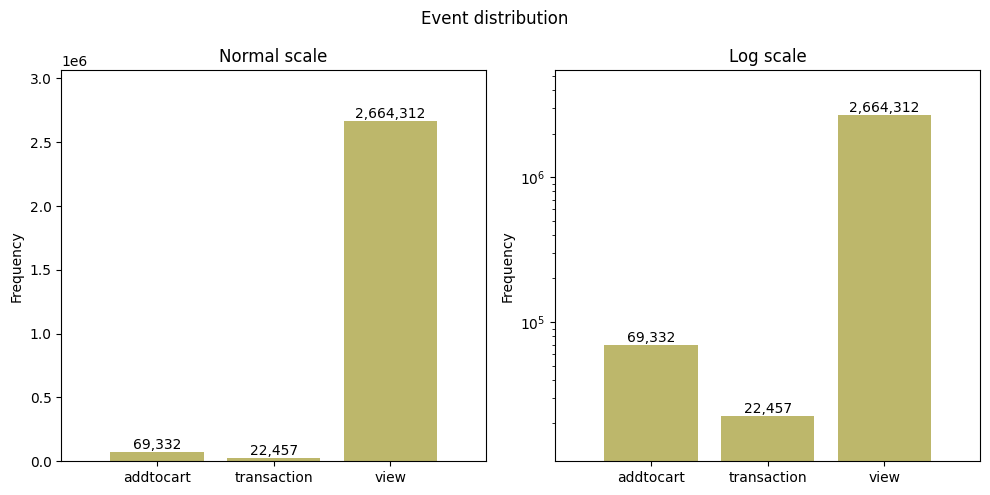

In [ ]:
#@title #### Event frequency distribution

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

events_freqdist = events.groupby('event')['event'].count()

def plot_on_ax(_ax):
    fd = _ax.bar(events_freqdist.index, events_freqdist.values, color="darkkhaki")
    _ax.bar_label(fd, fmt="{:,.0f}")

ax = axes[0]
plot_on_ax(ax)
ax.set_title("Normal scale")

ax = axes[1]
plot_on_ax(ax)
ax.set_yscale('log')
ax.set_title("Log scale")

for ax in axes:
    ax.set_ylabel('Frequency')
    ax.margins(.15)

plt.suptitle('Event distribution')
plt.tight_layout()
plt.show()

del plot_on_ax

### Transaction events

In [ ]:
condTransaction = events['event'] == 'transaction'
transaction_events = events[condTransaction]
print("`transaction_events` shape:", transaction_events.shape)
assert transaction_events['transactionid'].notna().all()

`transaction_events` shape: (22457, 5)


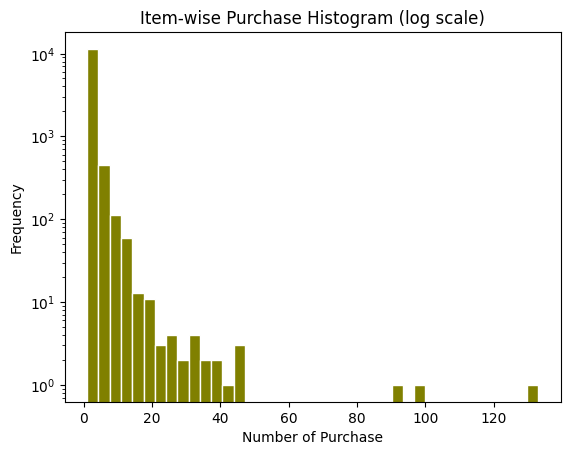

In [ ]:
plt.hist(transaction_events.groupby(by='itemid')['transactionid'].count().reset_index(drop=True),
         bins=40, edgecolor="white", color="olive")

plt.title("Item-wise Purchase Histogram (log scale)")
plt.xlabel("Number of Purchase")
plt.ylabel("Frequency")
plt.yscale('log')
plt.show()

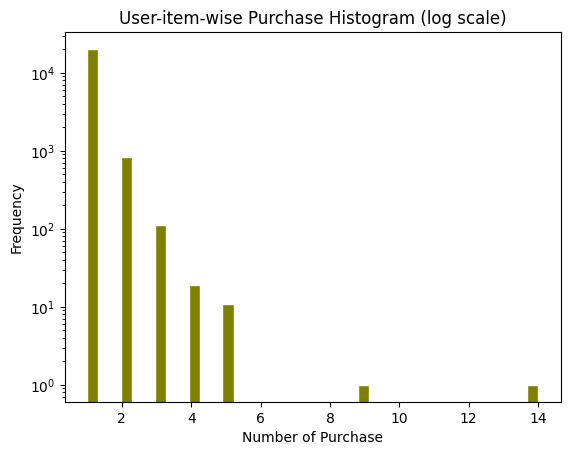

In [ ]:
plt.hist(transaction_events.groupby(by=['visitorid', 'itemid'])['transactionid'].count().reset_index(drop=True),
         bins=40, edgecolor="white", color="olive")

plt.title("User-item-wise Purchase Histogram (log scale)")
plt.xlabel("Number of Purchase")
plt.ylabel("Frequency")
plt.yscale('log')
plt.show()

# Implementations

## Preparation

In [ ]:
# designated user
designated_visitor_id = 102019
assert transaction_events[transaction_events['visitorid'] == designated_visitor_id]['itemid'].count() > 0

## 1. User-based Purchase History Similarity

In [ ]:
visitor_item_pivot = transaction_events.pivot_table(index='visitorid', columns='itemid', values='event', aggfunc='any').fillna(0).astype(int)
visitor_item_pivot
assert visitor_item_pivot.sum().sum() == transaction_events.groupby(by=['visitorid', 'itemid'])['itemid'].count().reset_index(drop=True).count()

itemid,15,19,25,42,147,168,199,212,233,304,...,466319,466321,466342,466443,466464,466526,466603,466614,466710,466861
visitorid,,,,,,,,,,,,,,,,,,,,,
172,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
186,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
264,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
419,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
539,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1406787,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1406981,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1407070,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
visitor_item_similarity = cosine_similarity(visitor_item_pivot)
visitor_item_similarity

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [ ]:
(visitor_item_pivot.shape, visitor_item_similarity.shape)

((11719, 12025), (11719, 11719))

In [ ]:
visitor_loc = visitor_item_pivot.index.get_loc(designated_visitor_id)
selected_visitor_pivot = visitor_item_pivot.iloc[visitor_loc, :]
selected_visitor_similarity = visitor_item_similarity[visitor_loc, :]

In [ ]:
class UserBasedCollabFilterRecommender():
    def __init__(self, pivot, similarity, userid, k, top_n):
        self.userid = userid
        self.pivot = pivot
        self.similarity = similarity
        self.k = k
        self.top_n = top_n

        self.interacted_itemids = None
        self.similar_userids = None

        print("User-based Collaborative Filter Recommender")
        print(f"Initialized with userid = {self.userid}, k = {self.k}, top_n = {self.top_n}", "\n\n")

    def recommend(self):
        # user elements
        user_loc = self.pivot.index.get_loc(self.userid)
        ## `loc` notation is used instead of `idx`:
        ##  ->  refers to in-place integer-based location
        ##      regardless to the actual index
        user_pivot = self.pivot.iloc[user_loc, :]
        user_similarity = self.similarity[user_loc, :]


        # already interacted
        interacted_mask = user_pivot[user_pivot.gt(0)]
        interacted_itemids = interacted_mask.index

        self.interacted_itemids = interacted_itemids
        print("Item # already interacted with:\n\n", self.interacted_itemids.to_list(), "\n\n")


        # k most similar (different than the designated) users
        similar_user_locs = user_similarity.argpartition(-(self.k+1))[-(self.k+1):]
        similar_userids = self.pivot.iloc[similar_user_locs].index

        self.similar_userids = similar_userids
        print(f"K={self.k} most similar user #:\n\n", self.similar_userids.to_list(), "\n\n")

        if np.isin(similar_user_locs, user_loc).any():
            similar_user_locs = similar_user_locs[similar_user_locs != user_loc]

        assert np.invert(np.isin(user_loc, similar_user_locs))
        assert (len(similar_user_locs) > (k/2)) & (len(similar_user_locs) <= k)

        # recommendation
        items_recommended = (self.pivot.iloc[similar_user_locs]
                                           .sum(axis=0)
                                           .astype('int')
                                           .rename('Transaction frequency')
                                           .where(lambda x: x > 0)
                                           .dropna()
                                           .sort_values(ascending=False)[:self.top_n]
                                           .astype('int')
                            )
        print("Recommended item #:\n\n", items_recommended.index.to_list(), "\n\n")

        assert (~np.isin(interacted_itemids, items_recommended)).all()
        assert len(items_recommended) <= self.top_n

        return items_recommended

    def get_interacted_items(self):
        assert self.interacted_itemids is not None
        return self.interacted_itemids.to_list()

    def get_similar_users(self):
        assert self.similar_userids is not None
        return self.similar_userids.to_list()

In [ ]:
K = 5
N = 5

model = UserBasedCollabFilterRecommender(visitor_item_pivot, visitor_item_similarity, designated_visitor_id, K, N)
recommendation = model.recommend()

User-based Collaborative Filter Recommender
Initialized with userid = 102019, k = 5, top_n = 5 


Item # already interacted with:

 [49521, 150318] 


K=5 most similar user #:

 [479343, 479891, 480000, 480011, 953198, 102019] 


Recommended item #:

 [98065, 150318, 156468, 305656, 369447] 


